## Test Task

### Задача:
- виділити групи блогерів так, щоб ці групи якомога більше відрізнялися між
собою.
- описати створені групи блогерів (чому групи розділились і як це можна
використати)
- розробити рекомендаційний алгоритм для замовлення реклами у блогерів з
метою просування продукту компанії

### Опис датасетів:

1) `autors.csv`

- `Author ID` - id автора
- `Name` - назва автора
- `MEIBI` - метрика ідентифікації впливу блогера
- `MEIBIX` - метрика для визначення якості блогу щодо кількості та часу посилань на
коментарі
- `Average Number Of Words In Posts` - середня кількість слів у постах
- `Average Number Of Words In Posts (without stopwords)` - середня кількість слів у постах
без шумових слів

2) `posts.csv`

- `Post ID` - id поста
- `Title` - заголовок
- `Blogger's Name` - ім’я блорега
- `Blogger's ID` - id блогера
- `Number of comments` - кількість коментарів
- `Content` - текст поста
- `Date` - дата створення поста
- `Number of retrieved inlinks` - Кількість отриманих посилань
- `Number of retrieved comments` - Кількість отриманих коментарів

3) `companies.csv`

- `Name` - назва компанії
- `Year Founded` - рік заснування
- `Industry` - тематика компанії
- `Size Range` - величина компанії
- `Country` - країна реєстрації компанії
- `Current Employee Estimate` - сумарна кількість співробітників

### 1. Імпорт бібліотек

In [1]:
import pandas as pd
from src import (prepare_data,
extract_content_features,
create_enhanced_features,
enhanced_clustering_with_content,
analyze_cluster_content_themes,
detailed_cluster_analysis_with_content,
content_based_recommendations,
display_recommendations,
create_enhanced_visualizations)

import warnings
warnings.filterwarnings('ignore')

authors_df = pd.read_csv('autors.csv')
companies_df = pd.read_csv('companies.csv')
posts_df = pd.read_csv('posts.csv')

In [12]:
def run_enhanced_analysis(authors_df, companies_df, posts_df):
    """Run the complete enhanced analysis with progress tracking"""
    
    print("\n STARTING ENHANCED BLOG ANALYSIS")
    print("="*50)
    
    # 1. Prepare data
    print("\n Preparing data...")
    authors_df, companies_df, posts_df, authors_posts_df = prepare_data(authors_df, companies_df, posts_df)
    
    # 2. Extract content features (with progress bars)
    tfidf_df, author_content_stats, feature_names = extract_content_features(authors_posts_df)
    
    # 3. Create enhanced features
    print("\n Creating enhanced features...")
    enhanced_df = create_enhanced_features(authors_posts_df)
    
    # 4. Define behavioral features
    behavioral_features = [
        'meibi', 'meibix', 'avg_engagement', 'word_efficiency', 
        'consistency', 'posting_frequency'
    ]
    
    # 5. Perform clustering
    print("\n Performing enhanced clustering...")
    clustered_df, model, combined_features, labels, scalers = enhanced_clustering_with_content(
        enhanced_df, behavioral_features, tfidf_df
    )
    
    # 6. Analyze cluster themes
    cluster_themes = analyze_cluster_content_themes(clustered_df, tfidf_df, feature_names)
    
    # 7. Detailed cluster analysis
    cluster_analysis = detailed_cluster_analysis_with_content(
        clustered_df, cluster_themes, author_content_stats
    )
    
    # 8. Generate recommendations (with progress bars)
    recommendations = content_based_recommendations(
        companies_df, clustered_df, cluster_analysis, cluster_themes
    )
    
    # 9. Display recommendations in human-readable format
    display_recommendations(recommendations, companies_df, top_n=5)
    
    # 10. Create visualizations
    print("\n📈 Creating visualizations...")
    create_enhanced_visualizations(
        clustered_df, combined_features, labels, cluster_analysis, cluster_themes
    )
    
    print("\n ANALYSIS COMPLETED SUCCESSFULLY!")
    
    return clustered_df, recommendations, cluster_analysis, cluster_themes


Processing authors:   7%|█▌                     | 7/107 [00:00<00:01, 66.36it/s]


 STARTING ENHANCED BLOG ANALYSIS

 Preparing data...
Extracting content features...
   • Preparing text data...
   • Aggregating text by author...


   • Computing TF-IDF features...


Computing metrics:   1%|▏                       | 1/107 [00:00<00:17,  5.99it/s]

   • Computing content metrics...


Content feature extraction completed!

 Creating enhanced features...

 Performing enhanced clustering...


Processing companies:   1%|▏                    | 6/750 [00:00<00:13, 54.90it/s]

Optimal number of clusters: 3
Silhouette Score: 0.372

CONTENT THEMES BY CLUSTER

Cluster 0 - Primary Topics:
   Key themes: 8211 | search | media | year | app
   • 8211: 0.154
   • search: 0.125
   • media: 0.095

Cluster 1 - Primary Topics:
   Key themes: 8211 | users | web | service | people
   • 8211: 0.152
   • users: 0.138
   • web: 0.119

Cluster 2 - Primary Topics:
   Key themes: google | twitter | facebook | users | million
   • google: 0.280
   • twitter: 0.204
   • facebook: 0.201

DETAILED CLUSTER ANALYSIS

Diverse Content Creators
Rich vocabulary and varied topics
├─ Size: 21 authors
├─ Influence Score: 0.5
├─ Engagement Level: 41.9
├─ Content Quality: 0.731
├─ Vocabulary Richness: 0.613
├─ Posting Frequency: 0.0130 posts/day
├─ Content Themes: 8211 • search • media • year • app
└─ Featured Authors: Roxanne Varza | Gené Teare | Dimitris Kalavros-Gousiou

Diverse Content Creators
Rich vocabulary and varied topics
├─ Size: 80 authors
├─ Influence Score: 15.1
├─ Engagement Le

Processing companies: 100%|███████████████████| 750/750 [00:12<00:00, 62.49it/s]



TOP 5 COMPANY RECOMMENDATIONS

1. blue point technologies
Industry: information technology and services
Size: 1 - 10 employees
Strategy: High-engagement niche experts
Relevant Topics: 8211 • search • media • 8211 • users

RECOMMENDED AUTHORS:
----------------------------------------

1. Eric Clemons ****
   Influence Score: 1.0
   Engagement: 280.0
   Content Match: 0/10
   Overall Score: 80.8
   Why: Highly engaging content creator

2. Vivek Wadhwa **
   Influence Score: 13.0
   Engagement: 172.7
   Content Match: 0/10
   Overall Score: 57.4
   Why: Highly engaging content creator

3. Michael Arrington **
   Influence Score: 114.0
   Engagement: 57.7
   Content Match: 0/10
   Overall Score: 54.0
   Why: Top-tier influencer with massive reach

2. call a cab limited
Industry: telecommunications
Size: 1 - 10 employees
Strategy: High-engagement niche experts
Relevant Topics: 8211 • users • web

RECOMMENDED AUTHORS:
----------------------------------------

1. Eric Clemons ****
   Influen

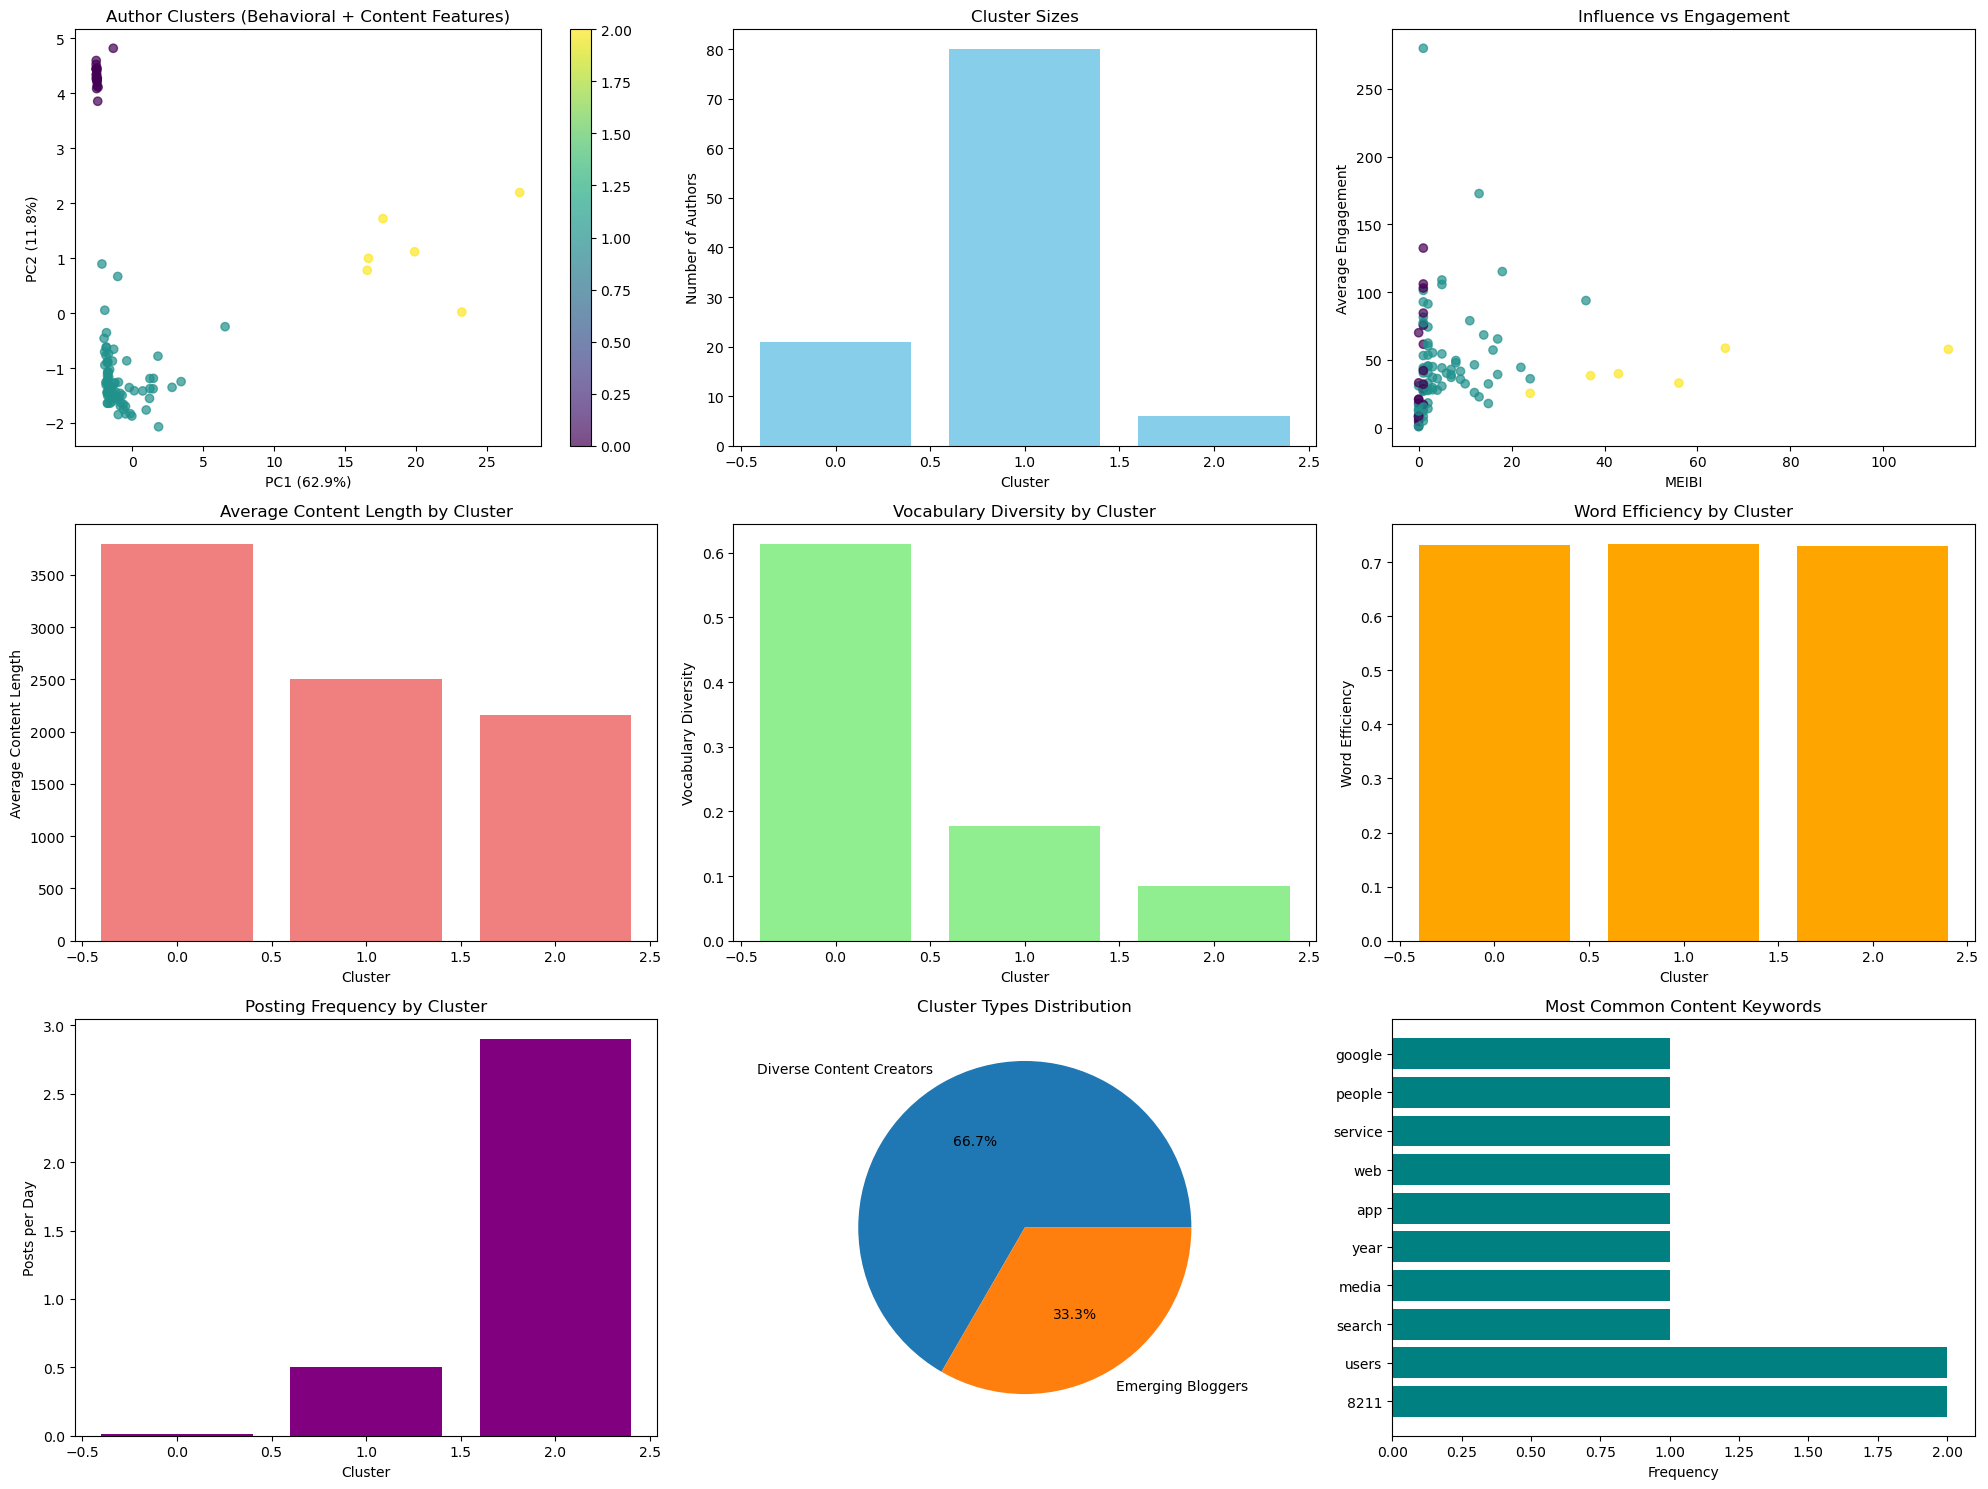


 ANALYSIS COMPLETED SUCCESSFULLY!


(       post_id                                              title  \
 0            1  We Just Tested Twitter&#8217;s @anywhere Platf...   
 1            2  Facebook To Launch &#8216;Relationships&#8217;...   
 2            6  Blippy Does An End Run, Harnesses Gmail OAuth ...   
 3            9   Behind The Scenes Of YouTube&#8217;s ASCII Prank   
 4           14  RethinkDB Raises $1.2 Million For Its Database...   
 ...        ...                                                ...   
 19373    19258                 Netvibes &#8211; Personal homepage   
 19374    19259                             Editorial: On Mash-ups   
 19375    19322                        Profile &#8211; VitalSource   
 19376    19348                              Profile &#8211; Chalk   
 19377    19357                                               Jyve   
 
       blogger's_name  blogger's_id  number_of_comments  \
 0      Jason Kincaid             1                  14   
 1      Jason Kincaid             1     

In [13]:
run_enhanced_analysis(authors_df, companies_df, posts_df)